# LLM inference Speed of Light measurements

This document will estimate speed of light for LLM inference, assuming a transformer autoregressive architecture. We will only look at the token generation phase (and ignore prompt processing).

In [4]:
# for consistency we will assume HF-compatible hyper-parameter names
class Model():
    def __init__(self, name, hidden_size, intermediate_size, num_attention_heads, num_key_value_heads, num_hidden_layers, vocab_size, num_ffn=3, tied_embeddings=False):
        self.name = name
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_attention_heads = num_attention_heads
        self.num_key_value_heads = num_key_value_heads
        self.num_hidden_layers = num_hidden_layers
        self.vocab_size = vocab_size
        self.num_ffn = num_ffn
        self.tied_embeddings = tied_embeddings

    def params(self):
        # for simplicity we omit normalization layers and biases
        dim = self.hidden_size
        kvdim = dim // self.num_attention_heads * self.num_key_value_heads
        res = 0
        res += self.vocab_size * dim # embed
        res += self.num_hidden_layers * dim * dim # attn query
        res += self.num_hidden_layers * dim * kvdim * 2 # attn key, value
        res += self.num_hidden_layers * dim * dim # attn output
        res += self.num_hidden_layers * dim * self.intermediate_size * self.num_ffn # ffn
        if not self.tied_embeddings:
            res += self.vocab_size * dim # output
        return res

    def __str__(self):
        return f'{self.name} {self.params()/1e9:.1f}B'

In [5]:
# let's declare a few model configurations and print their sizes
llama7b = Model('Llama-7b', 4096, 11008, 32, 32, 32, 32000)
llama70b = Model('Llama-70b', 8192, 28672, 64, 8, 80, 32000)
mistral7b = Model('Mistral-7b', 4096, 14336, 32, 8, 32, 32000)
opt7b = Model('opt-7b', 4096, 16384, 32, 32, 32, 50272, num_ffn=2, tied_embeddings=True)
phi2 = Model('phi-2', 2560, 10240, 32, 32, 32, 51200, num_ffn=2)

str(llama7b), str(llama70b), str(mistral7b), str(opt7b), str(phi2)

('Llama-7b 6.7B',
 'Llama-70b 69.0B',
 'Mistral-7b 7.2B',
 'opt-7b 6.6B',
 'phi-2 2.8B')

In [6]:
# when running model inference, after every token we store intermediate k/v in kv cache
# note that the use of GQA (group query attention) significantly reduces kv cache size
def kvcache(model, seq_len, batch_size):
    dim = model.hidden_size
    kvdim = dim // model.num_attention_heads * model.num_key_value_heads
    return batch_size * model.num_hidden_layers * seq_len * kvdim * 2

kvcache(llama7b, 4096, 1), kvcache(mistral7b, 4096, 1)

(1073741824, 268435456)

In [7]:
# bandwidth is in bytes/s, flops/tensorops are in ops/s
class GPU():
    def __init__(self, name, bandwidth, flops, tensorops):
        self.name = name
        self.bandwidth = bandwidth
        self.flops = flops
        self.tensorops = tensorops

    def __str__(self):
        return self.name

In [8]:
# note: flops here are tracked for fp32 (both SM and tensor cores); in practice when using tensor cores we can probably expect 2x higher throughput from bf16/fp16
rtx4090 = GPU('RTX 4090', 1008e9, 83e12, 660e12)
a100_40 = GPU('A100 40GB PCIe', 1555e9, 19.5e12, 156e12)
a100_80 = GPU('A100 80GB PCIe', 1935e9, 19.5e12, 156e12)
h100 = GPU('H100 PCIe', 2000e9, 51e12, 758e12)

In [9]:
# estimate batch latency for a given model and GPU
# we assume auto-regressive inference and independent sequences: each batch element belongs to a separate sequence and has a separate slice of KV cache
# to convert latency to throughput, divide batch size by latency
def latency(gpu, model, seq_len, batch_size, modelbits=16, cachebits=16, tensorcores=False):
    modelbytes = int(model.params() * modelbits / 8)
    if tensorcores:
        # round batch size to 16 as tensor cores operate on 16x16 matrices
        modelops = model.params() * ((batch_size + 15) & ~15) * 2 # assume FMA per parameter
        modellat = max(modelbytes / gpu.bandwidth, modelops / gpu.tensorops)
    else:
        modelops = model.params() * batch_size * 2 # assume FMA per parameter
        modellat = max(modelbytes / gpu.bandwidth, modelops / gpu.flops)
    # assume tensor cores aren't used for attention
    kvbytes = int(kvcache(model, seq_len, batch_size) * cachebits / 8)
    kvops = kvcache(model, seq_len, batch_size) * 2 # assume FMA per parameter
    kvlat = max(kvbytes / gpu.bandwidth, kvops / gpu.flops)
    return modellat + kvlat

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Token throughput: A100 40GB PCIe - Llama-7b 6.7B')

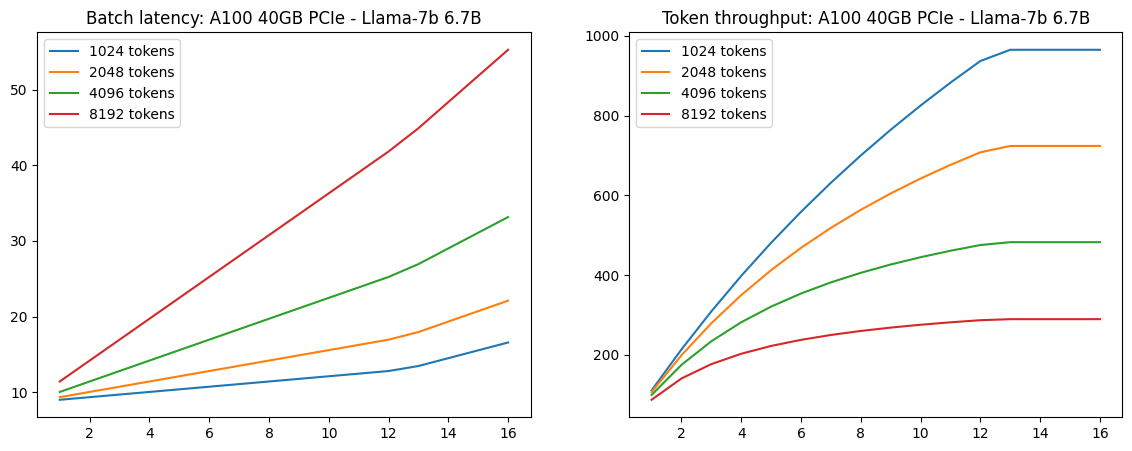

In [51]:
# plot latency and throughput for different batch sizes on A100 for a few sequence lengths
gpu = a100_40
model = llama7b
batchr = range(1, 17)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
for seq in [1024, 2048, 4096, 8192]:
    lat = [1000 * latency(gpu, model, seq, bs) for bs in batchr]
    plt.plot(batchr, lat, label=f'{seq} tokens')
plt.legend()
plt.title(f"Batch latency: {gpu} - {model}")
plt.subplot(1, 2, 2)
for seq in [1024, 2048, 4096, 8192]:
    thr = [bs / latency(gpu, model, seq, bs) for bs in batchr]
    plt.plot(batchr, thr, label=f'{seq} tokens')
plt.legend()
plt.title(f"Token throughput: {gpu} - {model}")


Text(0.5, 1.0, 'Token throughput (TC): H100 PCIe - Llama-7b 6.7B')

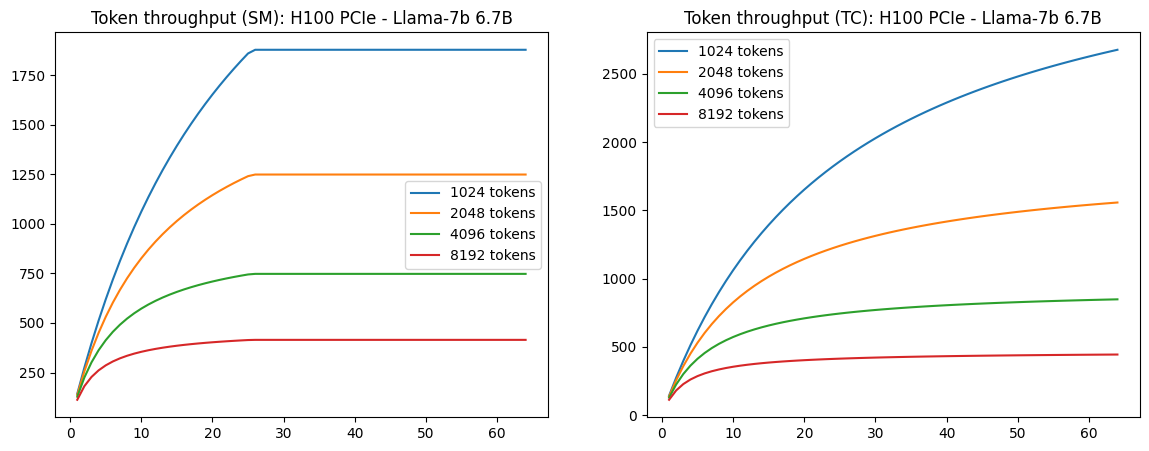

In [58]:
# plot throughput for different sequence lengths on A100 for a few batch sizes with and without tensor cores
# note: we ignore the fact that large batches will run out of memory
gpu = h100
model = llama7b
batchr = range(1, 65)
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharex = ax1)
# plt.subplot(1, 2, 1)
for seq in [1024, 2048, 4096, 8192]:
    thr = [bs / latency(gpu, model, seq, bs) for bs in batchr]
    ax1.plot(batchr, thr, label=f'{seq} tokens')
plt.legend()
plt.title(f"Token throughput (SM): {gpu} - {model}")
plt.subplot(1, 2, 2)
for seq in [1024, 2048, 4096, 8192]:
    thr = [bs / latency(gpu, model, seq, bs, tensorcores=True) for bs in batchr]
    ax2.plot(batchr, thr, label=f'{seq} tokens')
plt.legend()
plt.title(f"Token throughput (TC): {gpu} - {model}")